# Shapiq for Data Valuation
On this page we demonstrate two examples for using Shapiq for Data valuation.
The first example demonstrates this for a synthetic dataset, and the second for a real dataset.
In data valuation we are interested given a training and testing dataset to evaluate the contribution of each training point to the model's performance on the test data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

%matplotlib inline
import matplotlib_inline

import shapiq
from shapiq.plot._config import COLORS_K_SII, RED

print(f"Shapiq version: {shapiq.__version__}")

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

Shapiq version: 1.2.3.9000


## Synthetic Data
In this example we generate a synthetic classification dataset with 2 features, and 22 samples.
The dataset consists of two classes, each with 11 samples.
The data is generated from two multivariate normal distributions with different means and covariances.
This is done in such a way that the two classes are linearly separable.


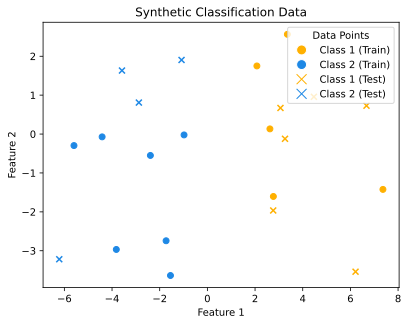

In [2]:
def plot_synthetic_data(ax, X_train, y_train, X_test, y_test, title) -> None:
    ax.set_title(title)
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c=[COLORS_K_SII[i] for i in y_train],
        label="Training Points",
        marker="o",
    )
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=[COLORS_K_SII[i] for i in y_test],
        label="Test Points",
        marker="x",
    )
    # Manually create legend entries
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=COLORS_K_SII[i],
            markersize=10,
            label=f"Class {i} (Train)",
        )
        for i in [1, 2]
    ]
    handles += [
        plt.Line2D(
            [0],
            [0],
            marker="x",
            linewidth=0,
            color=COLORS_K_SII[i],
            markerfacecolor=COLORS_K_SII[i],
            markersize=10,
            label=f"Class {i} (Test)",
        )
        for i in [1, 2]
    ]

    ax.legend(handles=handles, loc="upper right", title="Data Points")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


# Meta information
n_samples = 11
n_classes = 2
classes = list(range(1, n_classes + 1))
random_state = 1337
rng = np.random.default_rng(random_state)

# parameters for toy data
means = [(3, 0), (-3, 0)]
covs = [np.diag([3, 2]), np.diag([3, 3.5])]

# Construct the dataset
X = np.vstack(
    [rng.multivariate_normal(mean, cov, n_samples) for mean, cov in zip(means, covs, strict=False)],
)
y = np.hstack([np.full(n_samples, i) for i in classes])

# Build training and test set
n_samples_to_select = 10
random_indices = rng.choice(X.shape[0], n_samples_to_select, replace=False)
x_test, y_test = X[random_indices], y[random_indices]
x_train, y_train = np.delete(X, random_indices, axis=0), np.delete(y, random_indices, axis=0)
fig, ax = plt.subplots()

plot_synthetic_data(ax, x_train, y_train, x_test, y_test, "Synthetic Classification Data")

To apply `shapiq` approximators we need to reformulate the task of data valuation into a cooperative game $(N,\nu)$.
We define $N$ as the set of training points $N = \{1, \ldots, n\}$ and the characteristic function $$\nu: 2^N \rightarrow \mathbb{R}$$ is then the accuracy the model achieves on the test points (cross) given the training points in $S$.


In [3]:
class SyntheticDataValuation(shapiq.Game):
    """The synthetic data valuation tasked modeled as a cooperative game.

    Args:
        classifier: A classifier object that has the methods fit and score.
        n_players: The number of players in the game.
        x_test: The test data.
        y_test: The test labels.

    """

    def __init__(self, classifier, n_players, x_train, y_train, x_test, y_test) -> None:
        self.classifier = classifier
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        empty_coalition_value = np.zeros((1, n_players), dtype=bool)
        self.normalization_value = float(self.value_function(empty_coalition_value)[0])
        super().__init__(n_players, normalization_value=self.normalization_value)

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        """Compute the value of the coalitions.

        Args:
            coalitions: A numpy matrix of shape (n_coalitions, n_players)

        Returns:
            A vector of the value of the coalition

        """
        values = []
        for coalition in coalitions:
            tmp_x_train = self.x_train[coalition]
            tmp_y_train = self.y_train[coalition]
            if len(tmp_x_train) == 0:
                # If the coalition is empty, the value is zero
                value = 0
            else:
                unique_targets = np.unique(tmp_y_train)
                if len(unique_targets) == 1:
                    # If we only have one class present in training data, we predict this class
                    value = np.mean(self.y_test == unique_targets[0])
                else:
                    # We have at least two classes, we fit the classifier
                    self.classifier.fit(tmp_x_train, tmp_y_train)
                    value = self.classifier.score(self.x_test, self.y_test)

            values.append(value)

        return np.array(values, dtype=float)

As our model we choose the `LinearSVC()`from `sklearn`.
To get first insights into the data valuation we can compute the value of the full and empty coalition.

In [4]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
n_players = x_train.shape[0]
data_valuation_game = SyntheticDataValuation(
    classifier=classifier,
    n_players=n_players,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

full_coalition = np.ones((1, n_players), dtype=bool)
empty_coalition = np.zeros((1, n_players), dtype=bool)
print("Full coalition value: ", data_valuation_game(full_coalition)[0])
print("Empty coalition value: ", data_valuation_game(empty_coalition)[0])

Full coalition value:  1.0
Empty coalition value:  0.0


The empty coalition value is $0.0$ as the model has no information about the data.
The full coalition value is $1.0$ as the model is trained on all data points, and they are linearly seperable.
For this we plot the decision boundary of the `LinearSVM` classifier for the training data and the corresponding test data.

/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


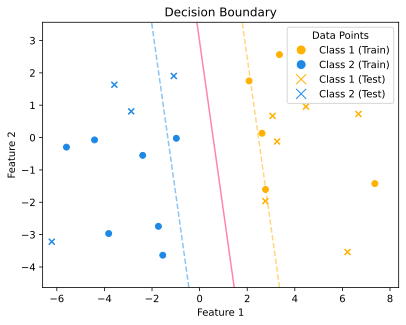

In [5]:
fig, ax = plt.subplots()

classifier.fit(x_train, y_train)
plot_synthetic_data(ax, x_train, y_train, x_test, y_test, "Synthetic Classification Data")

DecisionBoundaryDisplay.from_estimator(
    classifier,
    x_train,
    plot_method="contour",
    ax=ax,
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    colors=[COLORS_K_SII[1], RED.hex, COLORS_K_SII[2]],
    alpha=0.5,
)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Decision Boundary")
plt.show()

### Computing Shapley Values
Now we can compute the Shapley values for the data valuation game.
Intuitively, the Shapley values should all be positive as each training point makes the model more aware of the natural boundarie between the two classes.

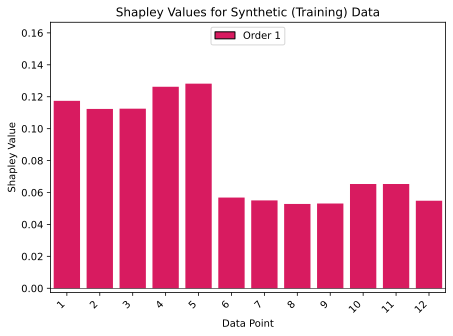

In [6]:
# Compute Shapley values with the ShapIQ approximator for the game function
exact_computer = shapiq.ExactComputer(n_players=n_players, game=data_valuation_game)
sv_values = exact_computer("SV")
sv_values.plot_stacked_bar(
    title="Shapley Values for Synthetic (Training) Data",
    xlabel="Data Point",
    ylabel="Shapley Value",
)
plt.show()

The Shapley values are all positive indicating that all data points have a positive impact on the model's performance.
Interestingly the Shapley values indicate the first five data points to be more important.

To understand this better notice that we have *four* blue test points and *six* orange test points.
If we are provided with a training set that contains only orange points, the model will have an accuracy of $0.6$.
On the other side, if we are provided with a training set that contains only blue points, the model will have an accuracy of $0.4$.
Thus having orange points in the training set is more important for the model's performance.
Meaning that the orange points are more important regarding accuracy.
These are exactly the first five data points, which are all orange.



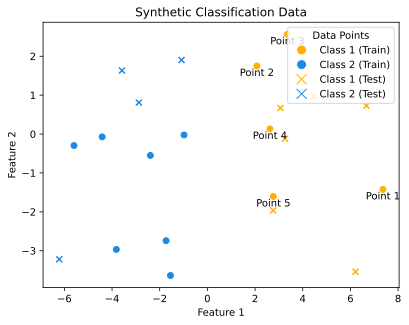

In [7]:
fig, ax = plt.subplots()

plot_synthetic_data(ax, x_train, y_train, x_test, y_test, "Synthetic Classification Data")
for i in range(5):
    ax.annotate(
        f"Point {i + 1}",
        (x_train[i, 0], x_train[i, 1]),
        textcoords="offset points",
        xytext=(0, -10),
        ha="center",
    )

plt.show()

### Corrupting the Data
We can now investigate the impact of corrupting the data on the Shapley values.
Currently the Shapley values are less interesting as we have a clear boundary between the two classes.
If we now corrupt the data by adding noise to the labels, the Shapley values should change and identify the corrupted samples.

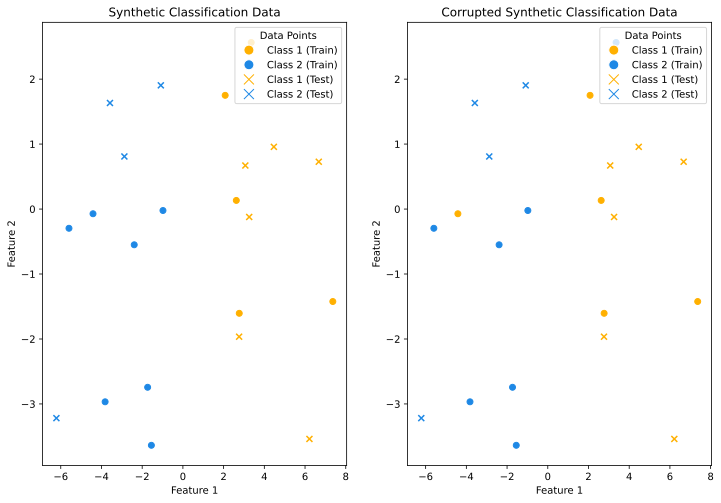

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

plot_synthetic_data(ax[0], x_train, y_train, x_test, y_test, "Synthetic Classification Data")

corrupted_x_train = x_train.copy()
corruped_y_train = y_train.copy()

corruped_y_train[5] = 1
corruped_y_train[2] = 2
plot_synthetic_data(
    ax[1],
    corrupted_x_train,
    corruped_y_train,
    x_test,
    y_test,
    "Corrupted Synthetic Classification Data",
)

Let us now look at the Shapley values for the corrupted data.
The Shapley values should now identify the corrupted samples.

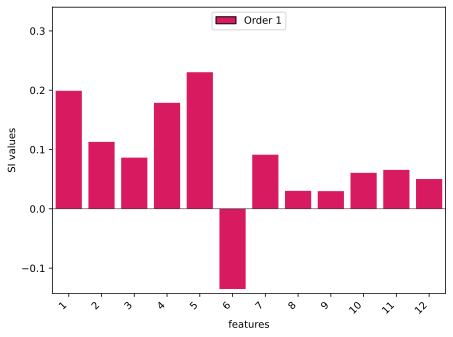

In [9]:
data_valuation_game = SyntheticDataValuation(
    classifier=classifier,
    n_players=n_players,
    x_train=corrupted_x_train,
    y_train=corruped_y_train,
    x_test=x_test,
    y_test=y_test,
)

# Compute Shapley values with the shapiq ExactComputer for the game function
exact_computer = shapiq.ExactComputer(n_players=n_players, game=data_valuation_game)
sv_values = exact_computer("SV")
sv_values.plot_stacked_bar()
plt.show()

With both corrupted samples identified by the Shapley values, we can now remove them from the training data and our model should perform better on the test data.

In [10]:
classifier.fit(corrupted_x_train, corruped_y_train)
print("Accuracy on test data before removing corrupted samples: ", classifier.score(x_test, y_test))

cleaned_x_train = np.delete(corrupted_x_train, [5, 2], axis=0)
cleaned_y_train = np.delete(corruped_y_train, [5, 2], axis=0)
classifier.fit(cleaned_x_train, cleaned_y_train)
print("Accuracy on test data after removing corrupted samples: ", classifier.score(x_test, y_test))

Accuracy on test data before removing corrupted samples:  1.0
Accuracy on test data after removing corrupted samples:  1.0


To verify this as sensible we plot the decision boundary of the `LinearSVM` classifier for the corrupted and cleaned training data and the corresponding test data.

/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


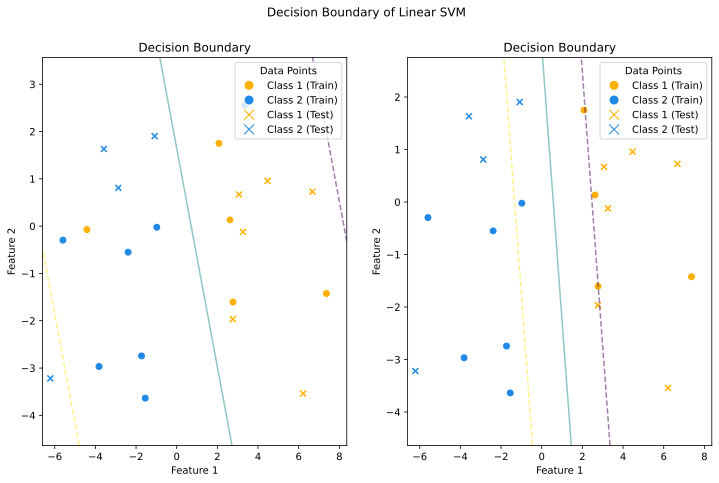

In [11]:
def plot_decision_boundary(ax, classifier, X_train, y_train, X_test, y_test) -> None:
    classifier.fit(X_train, y_train)
    plot_synthetic_data(ax, X_train, y_train, X_test, y_test, "Synthetic Classification Data")
    DecisionBoundaryDisplay.from_estimator(
        classifier,
        X_train,
        plot_method="contour",
        ax=ax,
        levels=[-1, 0, 1],
        linestyles=["--", "-", "--"],
        alpha=0.5,
    )
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title("Decision Boundary")


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
fig.suptitle("Decision Boundary of Linear SVM")
# Plot the decision boundary of the model with corrupted samples
plot_decision_boundary(ax[0], classifier, corrupted_x_train, corruped_y_train, x_test, y_test)

# Plot the decision boundary of the model with removed corrupted samples
plot_decision_boundary(ax[1], classifier, cleaned_x_train, cleaned_y_train, x_test, y_test)
plt.show()

## Real Data
We now demonstrate the data valuation for the [AdultCensus](../api/shapiq.datasets.rst) dataset.
Due to increasing runtime we choose a subset of the data, consisting of 200 samples.
Then we divide the data into training and test data at an 80/20 ratio.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = shapiq.load_adult_census(to_numpy=True)

X, y = X[:200], y[:200]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
classifier = DecisionTreeClassifier(random_state=random_state)
n_players = x_train.shape[0]
print("Players: ", n_players)

Players:  160


In [13]:
data_valuation_game = SyntheticDataValuation(
    classifier=classifier,
    n_players=n_players,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

In the next step we show how different budgets influence the quality of approximation and the corresponding accuracy tradeoff.

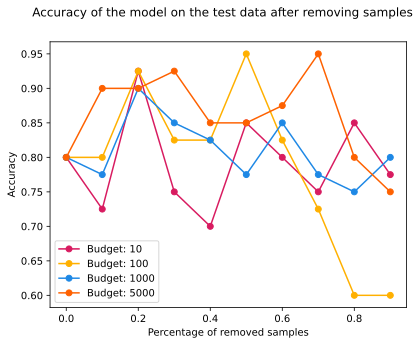

In [14]:
budgets = [10, 100, 1000, 5000]
erg = {}
for budget in budgets:
    # Compute Shapley interactions with the SVARM approximator for the game function
    approximator = shapiq.SVARM(n=n_players, random_state=random_state)
    shapley_approx = approximator.approximate(budget=budget, game=data_valuation_game)

    # Sort the approximated values of each player and get the keys
    players = np.array(range(n_players))
    sv_values = shapley_approx.values[1:]
    idx = np.argsort(sv_values)
    sorted_players = players[idx]

    # Compute the accuracy of the model for different amount of removed samples
    percent_removal = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    accuracies = []
    for p in percent_removal:
        n_samples_to_remove = int(p * n_players)
        removed_players = sorted_players[:n_samples_to_remove]
        cleaned_x_train = np.delete(x_train, removed_players, axis=0)
        cleaned_y_train = np.delete(y_train, removed_players, axis=0)
        classifier.fit(cleaned_x_train, cleaned_y_train)
        accuracies.append(classifier.score(x_test, y_test))
    erg[budget] = (percent_removal, accuracies)

# plot the results

fig, ax = plt.subplots()
fig.suptitle("Accuracy of the model on the test data after removing samples")
for i, (budget, (percent_removal, accuracies)) in enumerate(erg.items()):
    ax.plot(
        percent_removal,
        accuracies,
        label=f"Budget: {budget}",
        marker="o",
        linestyle="-",
        color=COLORS_K_SII[i],
    )
plt.xlabel("Percentage of removed samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Intuitively increasing amount of removed data samples with low Shapley values should yield a better model performance.
Increasing the budget yields a more clear effect for lower percentages.
For very high percentages the effect is less pronounced as the model is already trained on the most important samples.